## Shell Contact Example

In [1]:
# !pip install debugpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def compute_energy_grad_hess(Delta, delta, h, k_1):
    E = np.zeros_like(Delta)
    grad_E = np.zeros_like(Delta)
    hess_E = np.zeros_like(Delta)

    mask1 = (Delta >= 0) & (Delta <= 2 * h - delta)
    mask2 = (Delta > 2 * h - delta) & (Delta < 2 * h + delta)

    print("mask1: ", mask1)
    print("mask2: ", mask2)

    # Quadratic region
    E[mask1] = (2 * h - Delta[mask1]) ** 2
    grad_E[mask1] = -2 * (2 * h - Delta[mask1])
    hess_E[mask1] = 2.0

    # Smooth transition region
    exp_term = np.exp(k_1 * (2 * h - Delta[mask2]))
    log_term = np.log(1 + exp_term)
    denom = 1 + exp_term

    E[mask2] = (1 / k_1 * log_term) ** 2
    grad_E[mask2] = -2 * (1/k_1 * log_term) * (exp_term / denom)
    hess_E[mask2] = (
        2 * exp_term / (denom ** 2) *
        (log_term + exp_term)
    ) # corrected
    # hess_E[mask2] = (
    #     2 * exp_term / (k_1 * denom ** 2) *
    #     (log_term - (k_1 * exp_term / denom))
    # ) # incorrect

    return E, grad_E, hess_E

def finite_difference_check_energy_grad(Delta, delta, h, k_1, eps=1e-8):
    """
    Compares analytical grad_E (from compute_energy_grad_hess)
    against finite difference on E(Delta).
    
    Parameters:
    - Delta: np.array of input distances (shape [n])
    - delta, h, k_1: penalty parameters
    - eps: finite difference step size
    
    Returns:
    - numerical_grad_E: finite difference gradient (shape [n])
    - analytical_grad_E: computed gradient from function (shape [n])
    - rel_diff: relative difference (normed)
    """
    n = Delta.size
    numerical_grad_E = np.zeros(n)

    # Compute analytical E, grad_E
    E, analytical_grad_E, _ = compute_energy_grad_hess(Delta, delta, h, k_1)

    # Compute finite difference gradient
    for i in range(n):
        Delta_plus = Delta.copy()
        Delta_minus = Delta.copy()

        if Delta[i] == 0:
            Delta_minus[i] -= 0
            const = 1.0
        else:
            Delta_minus[i] -= eps
            const = 2.0

        Delta_plus[i] += eps

        E_plus, _, _ = compute_energy_grad_hess(Delta_plus, delta, h, k_1)
        E_minus, _, _ = compute_energy_grad_hess(Delta_minus, delta, h, k_1)

        # print("E_plus:", E_plus)
        # print("E_minus:", E_minus)

        numerical_grad_E[i] = (E_plus[i] - E_minus[i]) / (const * eps)

    # Relative difference
    rel_diff = np.linalg.norm(numerical_grad_E - analytical_grad_E) / (np.linalg.norm(analytical_grad_E) + 1e-12)

    return E, numerical_grad_E, analytical_grad_E, rel_diff


In [3]:
# Example setup
n_pairs = 10001
Delta = np.linspace(0.0, 0.2, n_pairs)  # sweep distances from 0 to 0.15

# Delta = np.array([0.105])

print("Delta:", Delta)

# Delta = np.random.rand(n_pairs)
delta = 0.01
h = 0.05

print("lower bound:", 2 * h - delta)
print("upper bound:", 2 * h + delta)

k_1 = 15 / delta

E_vals, num_grad, ana_grad, diff = finite_difference_check_energy_grad(Delta, delta, h, k_1)

print("Relative difference (grad E):", diff)
print("FDM grad_E:", num_grad)
print("Analytical grad_E:", ana_grad)


Delta: [0.0000e+00 2.0000e-05 4.0000e-05 ... 1.9996e-01 1.9998e-01 2.0000e-01]
lower bound: 0.09000000000000001
upper bound: 0.11
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False

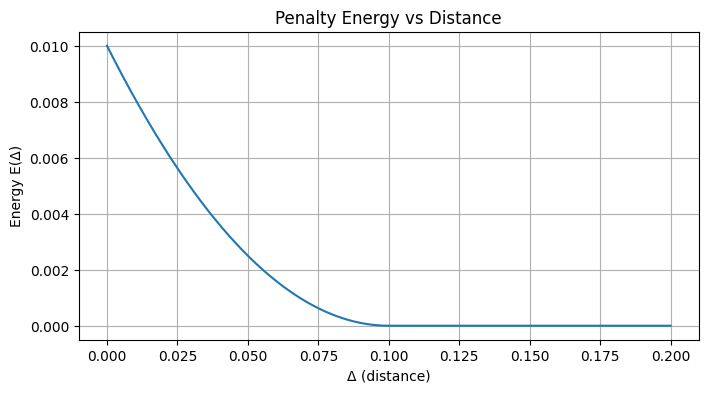

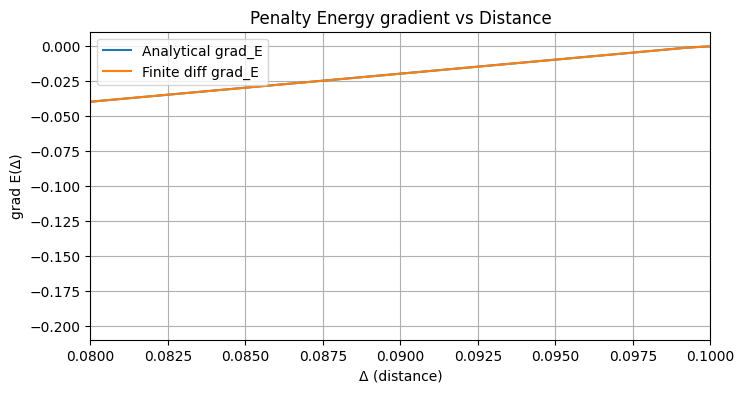

In [4]:
# Plot: Energy vs Δ
plt.figure(figsize=(8, 4))
plt.plot(Delta, E_vals)
plt.xlabel('Δ (distance)')
plt.ylabel('Energy E(Δ)')
plt.title('Penalty Energy vs Distance')
plt.grid(True)
# plt.xlim(0.08, 0.11)
# plt.ylim(0, 0.01)
plt.show()

# Plot: grad vs Δ
plt.figure(figsize=(8, 4))
plt.plot(Delta, ana_grad, label='Analytical grad_E')
plt.plot(Delta, num_grad, label='Finite diff grad_E')
plt.xlabel('Δ (distance)')
plt.ylabel('grad E(Δ)')
plt.xlim(0.08, 0.1)
# plt.ylim(-100, 20)
plt.legend()
plt.title('Penalty Energy gradient vs Distance')
plt.grid(True)
plt.show()

# # Plot: Gradients
# plt.figure(figsize=(10, 5))
# plt.plot(num_grad, label='Finite diff grad_E', marker='o')
# plt.plot(ana_grad, label='Analytical grad_E', marker='x')
# plt.xlabel('Pair index')
# plt.ylabel('Gradient w.r.t Δ')
# plt.title(f'Gradient Comparison (rel diff = {diff:.2e})')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Optional: Per-pair difference plot
# plt.figure(figsize=(10, 4))
# plt.plot(num_grad - ana_grad, label='Numerical - Analytical', marker='s')
# plt.xlabel('Pair index')
# plt.ylabel('Gradient difference')
# plt.title('Per-pair Gradient Difference')
# plt.legend()
# plt.grid(True)
# plt.show()

In [5]:
def finite_difference_check_hessian(Delta, delta, h, k_1, eps=1e-6):
    """
    Compares analytical hess_E (from compute_energy_grad_hess)
    against finite difference on grad_E(Delta).
    
    Parameters:
    - Delta: np.array of input distances (shape [n])
    - delta, h, k_1: penalty parameters
    - eps: finite difference step size
    
    Returns:
    - numerical_hess_E: finite difference hessian (shape [n])
    - analytical_hess_E: computed hessian from function (shape [n])
    - rel_diff: relative difference (normed)
    """
    n = Delta.size
    numerical_hess_E = np.zeros(n)

    # Compute analytical E, grad_E, hess_E
    _, _, analytical_hess_E = compute_energy_grad_hess(Delta, delta, h, k_1)

    # Compute finite difference second derivative (Hessian)
    for i in range(1,n):
        Delta_plus = Delta.copy()
        Delta_minus = Delta.copy()

        Delta_plus[i] += eps
        Delta_minus[i] -= eps

        E_plus, _, _ = compute_energy_grad_hess(Delta_plus, delta, h, k_1)
        E_0, _, _ = compute_energy_grad_hess(Delta, delta, h, k_1)
        E_minus, _, _ = compute_energy_grad_hess(Delta_minus, delta, h, k_1)

        numerical_hess_E[i] = (E_plus[i] - 2 * E_0[i] + E_minus[i]) / (eps ** 2)

    # Relative difference
    rel_diff = np.linalg.norm(numerical_hess_E - analytical_hess_E) / (np.linalg.norm(analytical_hess_E) + 1e-12)

    return numerical_hess_E, analytical_hess_E, rel_diff


In [15]:
# Example setup
n_pairs = 1001
Delta = np.linspace(0.0, 0.2, n_pairs)  # sweep distances from 0 to 0.15

# Delta = np.array([0.105])

print("Delta:", Delta)

# Delta = np.random.rand(n_pairs)
delta = 0.01
h = 0.05

print("lower bound:", 2 * h - delta)
print("upper bound:", 2 * h + delta)

k_1 = 15 / delta

num_hess, ana_hess, diff = finite_difference_check_hessian(Delta, delta, h, k_1)
print("Numerical Hessian:", num_hess)
print("Analytical Hessian:", ana_hess)
print("Relative difference:", diff)


Delta: [0.     0.0002 0.0004 ... 0.1996 0.1998 0.2   ]
lower bound: 0.09000000000000001
upper bound: 0.11
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False False]
mask1:  [ True  True  True ... False False False]
mask2:  [False False False ... False False F

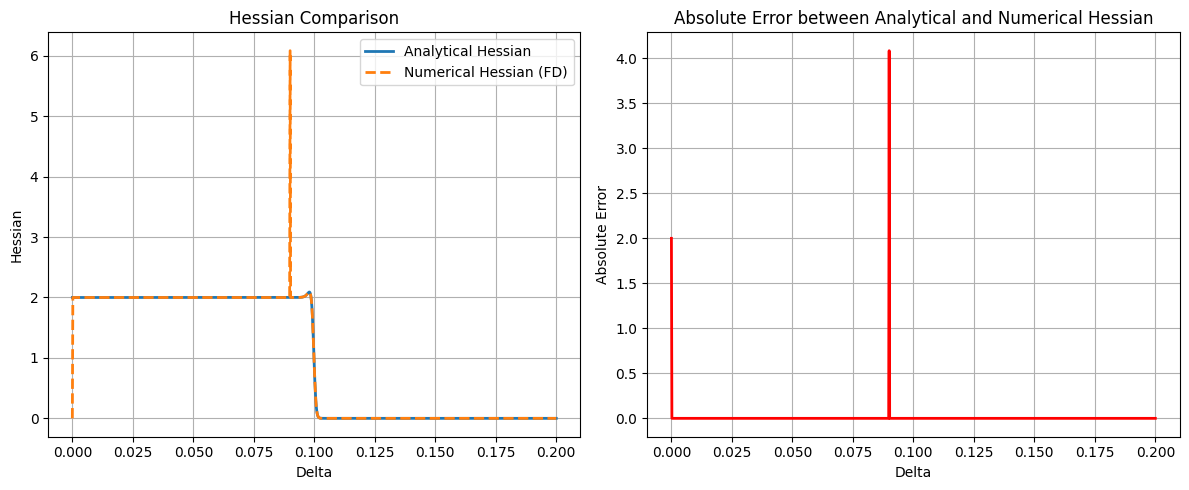

In [16]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot Hessians
plt.subplot(1, 2, 1)
plt.plot(Delta, ana_hess, label='Analytical Hessian', linewidth=2)
plt.plot(Delta, num_hess, '--', label='Numerical Hessian (FD)', linewidth=2)
plt.xlabel('Delta')
plt.ylabel('Hessian')
plt.title('Hessian Comparison')
plt.legend()
plt.grid(True)

# Plot absolute error
plt.subplot(1, 2, 2)
plt.plot(Delta, np.abs(ana_hess - num_hess), color='red', linewidth=2)
plt.xlabel('Delta')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between Analytical and Numerical Hessian')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
import numpy as np

def smooth_step(x):
    """Smooth step function g(x) using exponential bump."""
    f_x = np.exp(-1 / np.maximum(x, 1e-12))
    f_1_minus_x = np.exp(-1 / np.maximum(1 - x, 1e-12))
    return f_x / (f_x + f_1_minus_x)

def compute_energy_grad_hess_smooth(Delta, delta, h, k_1, epsilon):
    E = np.zeros_like(Delta)
    grad_E = np.zeros_like(Delta)
    hess_E = np.zeros_like(Delta)

    # Smooth bump functions around the two transition points
    left_center = 2 * h - delta
    right_center = 2 * h + delta

    # Rescale Delta into [0,1] zones for bump function
    S1 = smooth_step((Delta - (left_center - epsilon)) / (2 * epsilon))
    S2 = smooth_step((Delta - (right_center - epsilon)) / (2 * epsilon))

    # Compute regions
    quad_part = (2 * h - Delta) ** 2
    exp_term = np.exp(k_1 * (2 * h - Delta))
    log_term = np.log(1 + exp_term)
    log_part = (1 / k_1 * log_term) ** 2

    # Smooth blending
    E = (1 - S1) * quad_part + S1 * (1 - S2) * log_part

    # Gradients and Hessians
    # Derivative of quadratic part
    grad_quad = -2 * (2 * h - Delta)
    hess_quad = 2.0

    # Derivative of log part
    denom = 1 + exp_term
    grad_log = -2 * (1 / k_1 * log_term) * (exp_term / denom)
    hess_log = (
        2 * exp_term / (k_1 * denom ** 2) *
        (log_term - (k_1 * exp_term / denom))
    )

    # Combine with smooth weights
    grad_E = (1 - S1) * grad_quad + S1 * (1 - S2) * grad_log
    hess_E = (1 - S1) * hess_quad + S1 * (1 - S2) * hess_log

    return E, grad_E, hess_E


In [9]:
def finite_difference_check_energy_grad_smooth(Delta, delta, h, k_1, eps, change=1e-8):
    """
    Compares analytical grad_E (from compute_energy_grad_hess)
    against finite difference on E(Delta).
    
    Parameters:
    - Delta: np.array of input distances (shape [n])
    - delta, h, k_1: penalty parameters
    - eps: finite difference step size
    
    Returns:
    - numerical_grad_E: finite difference gradient (shape [n])
    - analytical_grad_E: computed gradient from function (shape [n])
    - rel_diff: relative difference (normed)
    """
    n = Delta.size
    numerical_grad_E = np.zeros(n)

    # Compute analytical E, grad_E
    E, analytical_grad_E, _ = compute_energy_grad_hess_smooth(Delta, delta, h, k_1, eps)

    # Compute finite difference gradient
    for i in range(n):
        Delta_plus = Delta.copy()
        Delta_minus = Delta.copy()
        Delta_plus[i] += change
        Delta_minus[i] -= change

        E_plus, _, _ = compute_energy_grad_hess_smooth(Delta_plus, delta, h, k_1, eps)
        E_minus, _, _ = compute_energy_grad_hess_smooth(Delta_minus, delta, h, k_1, eps)

        # print("E_plus:", E_plus)
        # print("E_minus:", E_minus)

        numerical_grad_E[i] = (E_plus[i] - E_minus[i]) / (2 * change)

    # Relative difference
    rel_diff = np.linalg.norm(numerical_grad_E - analytical_grad_E) / (np.linalg.norm(analytical_grad_E) + 1e-12)

    return E, numerical_grad_E, analytical_grad_E, rel_diff

In [10]:
# Example setup
n_pairs = 1001
Delta = np.linspace(0.0, 0.2, n_pairs)  # sweep distances from 0 to 0.15

# Delta = np.array([0.105])

print("Delta:", Delta)

# Delta = np.random.rand(n_pairs)
delta = 0.01
h = 0.05
epsilon = 0.001

print("lower bound:", 2 * h - delta)
print("upper bound:", 2 * h + delta)

k_1 = 15 / delta
# k_1 = 100

E_vals, num_grad, ana_grad, diff = finite_difference_check_energy_grad_smooth(Delta, delta, h, k_1, epsilon)

print("Relative difference (grad E):", diff)
print("FDM grad_E:", num_grad)
print("Analytical grad_E:", ana_grad)


Delta: [0.     0.0002 0.0004 ... 0.1996 0.1998 0.2   ]
lower bound: 0.09000000000000001
upper bound: 0.11
Relative difference (grad E): 3.7158816525990043e-09
FDM grad_E: [-0.2    -0.1996 -0.1992 ...  0.      0.      0.    ]
Analytical grad_E: [-0.2    -0.1996 -0.1992 ...  0.      0.      0.    ]


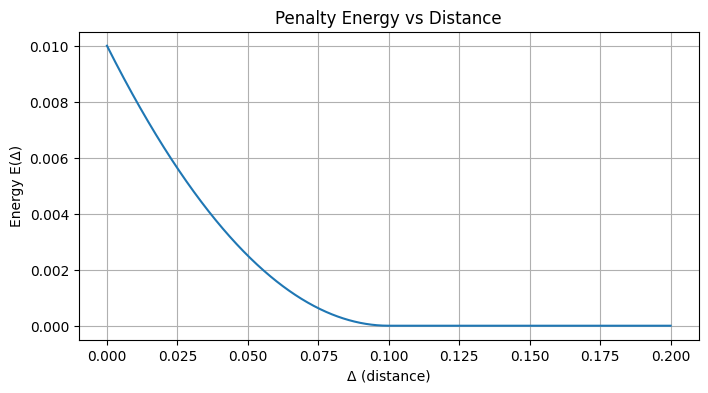

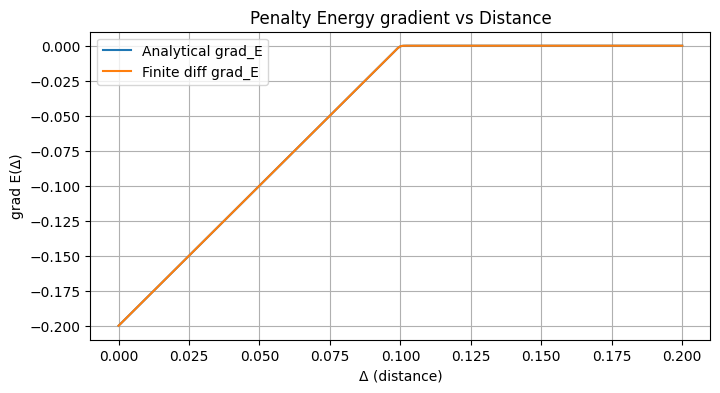

In [11]:
# Plot: Energy vs Δ
plt.figure(figsize=(8, 4))
plt.plot(Delta, E_vals)
plt.xlabel('Δ (distance)')
plt.ylabel('Energy E(Δ)')
plt.title('Penalty Energy vs Distance')
plt.grid(True)
# plt.xlim(0.08, 0.11)
# plt.ylim(0, 0.01)
plt.show()

# Plot: grad vs Δ
plt.figure(figsize=(8, 4))
plt.plot(Delta, ana_grad, label='Analytical grad_E')
plt.plot(Delta, num_grad, label='Finite diff grad_E')
plt.xlabel('Δ (distance)')
plt.ylabel('grad E(Δ)')
# plt.xlim(0.08, 0.11)
# plt.ylim(-100, 20)
plt.legend()
plt.title('Penalty Energy gradient vs Distance')
plt.grid(True)
plt.show()

# # Plot: Gradients
# plt.figure(figsize=(10, 5))
# plt.plot(num_grad, label='Finite diff grad_E', marker='o')
# plt.plot(ana_grad, label='Analytical grad_E', marker='x')
# plt.xlabel('Pair index')
# plt.ylabel('Gradient w.r.t Δ')
# plt.title(f'Gradient Comparison (rel diff = {diff:.2e})')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Optional: Per-pair difference plot
# plt.figure(figsize=(10, 4))
# plt.plot(num_grad - ana_grad, label='Numerical - Analytical', marker='s')
# plt.xlabel('Pair index')
# plt.ylabel('Gradient difference')
# plt.title('Per-pair Gradient Difference')
# plt.legend()
# plt.grid(True)
# plt.show()

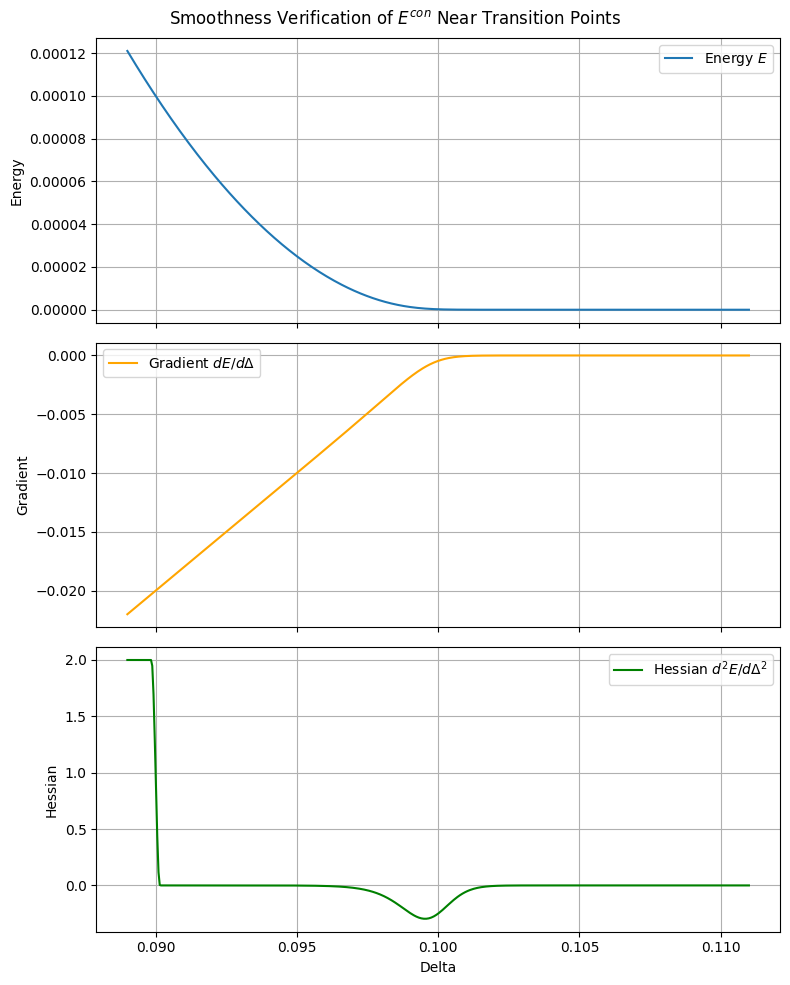

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Import your compute_energy_grad_hess here if it's in a separate module

# Parameters
h = 0.05
delta = 0.01
k_1 = 15/delta
epsilon = 0.0002

# Generate test range across transitions
Delta = np.linspace(2 * h - delta - 5 * epsilon, 2 * h + delta + 5 * epsilon, 500)

# Compute energy, gradient, Hessian
E, grad_E, hess_E = compute_energy_grad_hess_smooth(Delta, delta, h, k_1, epsilon)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(Delta, E, label='Energy $E$')
axs[0].set_ylabel('Energy')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(Delta, grad_E, label='Gradient $dE/d\Delta$', color='orange')
axs[1].set_ylabel('Gradient')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(Delta, hess_E, label='Hessian $d^2E/d\Delta^2$', color='green')
axs[2].set_ylabel('Hessian')
axs[2].set_xlabel('Delta')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Smoothness Verification of $E^{con}$ Near Transition Points')
plt.tight_layout()
plt.show()


mask1:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

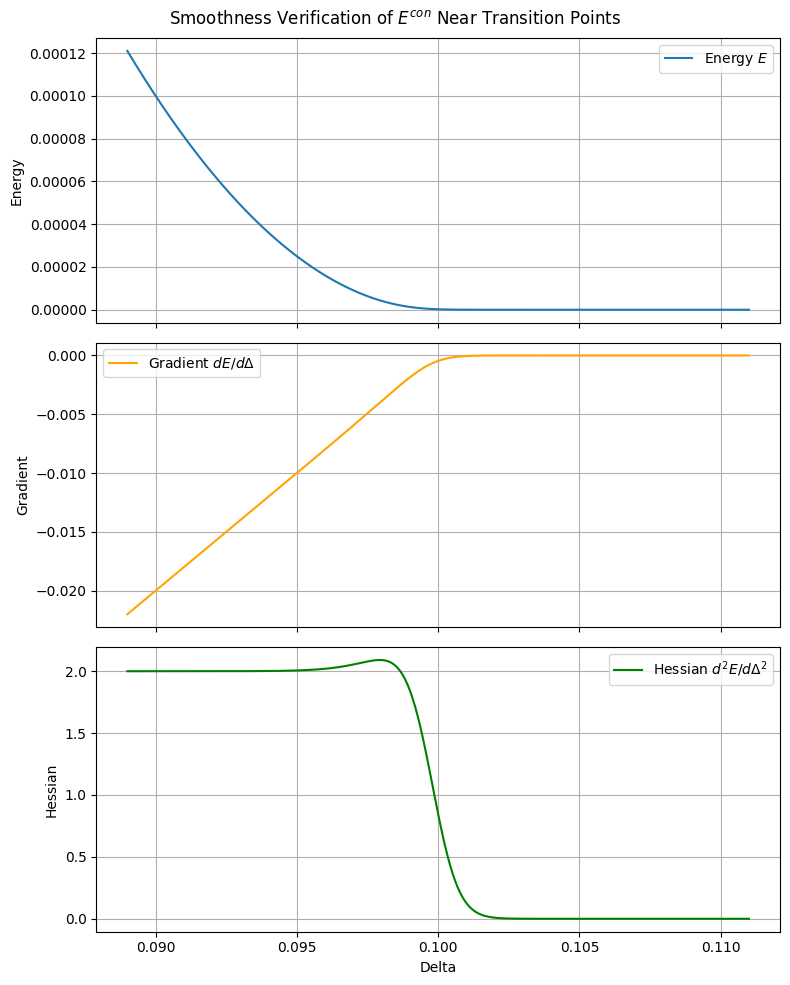

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Import your compute_energy_grad_hess here if it's in a separate module

# Parameters
h = 0.05
delta = 0.01
k_1 = 15/delta
epsilon = 0.0002

# Generate test range across transitions
Delta = np.linspace(2 * h - delta - 5 * epsilon, 2 * h + delta + 5 * epsilon, 500)

# Compute energy, gradient, Hessian
E, grad_E, hess_E = compute_energy_grad_hess(Delta, delta, h, k_1)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(Delta, E, label='Energy $E$')
axs[0].set_ylabel('Energy')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(Delta, grad_E, label='Gradient $dE/d\Delta$', color='orange')
axs[1].set_ylabel('Gradient')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(Delta, hess_E, label='Hessian $d^2E/d\Delta^2$', color='green')
axs[2].set_ylabel('Hessian')
axs[2].set_xlabel('Delta')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Smoothness Verification of $E^{con}$ Near Transition Points')
plt.tight_layout()
plt.show()


In [14]:
# Example setup
n_pairs = 101
Delta = np.linspace(0.0, 0.2, n_pairs)  # sweep distances from 0 to 0.15

# Delta = np.array([0.105])

print("Delta:", Delta)

# Delta = np.random.rand(n_pairs)
delta = 0.01
h = 0.05

print("lower bound:", 2 * h - delta)
print("upper bound:", 2 * h + delta)

k_1 = 100 / delta

E_vals, num_grad, ana_grad, diff = finite_difference_check_energy_grad_smooth(Delta, delta, h, k_1, eps = 1e-4)

print("Relative difference (grad E):", diff)
print("FDM grad_E:", num_grad)
print("Analytical grad_E:", ana_grad)

Delta: [0.    0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022
 0.024 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046
 0.048 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07
 0.072 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094
 0.096 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118
 0.12  0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142
 0.144 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166
 0.168 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19
 0.192 0.194 0.196 0.198 0.2  ]
lower bound: 0.09000000000000001
upper bound: 0.11
Relative difference (grad E): nan
FDM grad_E: [            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan -1.40000000e-01
 -1.36000000e-01 -1.32

/tmp/ipykernel_135636/3696676220.py:24: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(k_1 * (2 * h - Delta))
/tmp/ipykernel_135636/3696676220.py:29: RuntimeWarning: invalid value encountered in multiply
  E = (1 - S1) * quad_part + S1 * (1 - S2) * log_part
/tmp/ipykernel_135636/3696676220.py:38: RuntimeWarning: invalid value encountered in divide
  grad_log = -2 * (1 / k_1 * log_term) * (exp_term / denom)
/tmp/ipykernel_135636/3696676220.py:40: RuntimeWarning: overflow encountered in square
  2 * exp_term / (k_1 * denom ** 2) *
/tmp/ipykernel_135636/3696676220.py:40: RuntimeWarning: invalid value encountered in divide
  2 * exp_term / (k_1 * denom ** 2) *
/tmp/ipykernel_135636/3696676220.py:41: RuntimeWarning: invalid value encountered in divide
  (log_term - (k_1 * exp_term / denom))
